In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from typing import Tuple, Dict, List
from PIL import Image

# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.9.1+cu128


# Unet++ Architecture

In [4]:
#Define the Convolutional Block
class ConvoBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [5]:
#Define the UNet++ Architecture
class UnetPlusPlus(nn.Module):
    def __init__(self, in_channels: int =1, num_classes: int = 2, deep_supervision: bool = False, base_filters: int = 32):
        super(UnetPlusPlus, self).__init__()
        self.deep_supervision = deep_supervision

        #Filters sizes at each level
        filters = [base_filters * (2 ** i) for i in range(5)]

        #Encoder - Downsampling path
        self.conv0_0 = ConvoBlock(in_channels, filters[0])
        self.conv1_0 = ConvoBlock(filters[0], filters[1])
        self.conv2_0 = ConvoBlock(filters[1], filters[2])
        self.conv3_0 = ConvoBlock(filters[2], filters[3])
        self.conv4_0 = ConvoBlock(filters[3], filters[4])
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        #Dense Decoder
        self.conv0_1 = ConvoBlock(filters[0] + filters[1], filters[0])
        self.conv0_2 = ConvoBlock(filters[0] * 2 + filters[1], filters[0])
        self.conv0_3 = ConvoBlock(filters[0] * 3 + filters[1], filters[0])
        self.conv0_4 = ConvoBlock(filters[0] * 4 + filters[1], filters[0])

        #Level 1 dense connections
        self.conv1_1 = ConvoBlock(filters[1] + filters[2], filters[1])
        self.conv1_2 = ConvoBlock(filters[1] * 2 + filters[2], filters[1])
        self.conv1_3 = ConvoBlock(filters[1] * 3 + filters[2], filters[1])

        #Level 2 dense connections
        self.conv2_1 = ConvoBlock(filters[2] + filters[3], filters[2])
        self.conv2_2 = ConvoBlock(filters[2] * 2 + filters[3], filters[2])

        #Level 3 dense connections
        self.conv3_1 = ConvoBlock(filters[3] + filters[4], filters[3])


        #Upsampling Layers
        self.up1_0 = nn.ConvTranspose2d(filters[1], filters[1], kernel_size=2, stride=2)
        self.up2_0 = nn.ConvTranspose2d(filters[2], filters[2], kernel_size=2, stride=2)
        self.up3_0 = nn.ConvTranspose2d(filters[3], filters[3], kernel_size=2, stride=2)
        self.up4_0 = nn.ConvTranspose2d(filters[4], filters[4], kernel_size=2, stride=2)

        self.up1_1 = nn.ConvTranspose2d(filters[1], filters[1], kernel_size=2, stride=2)
        self.up2_1 = nn.ConvTranspose2d(filters[2], filters[2], kernel_size=2, stride=2)
        self.up3_1 = nn.ConvTranspose2d(filters[3], filters[3], kernel_size=2, stride=2)

        self.up1_2 = nn.ConvTranspose2d(filters[1], filters[1], kernel_size=2, stride=2)
        self.up2_2 = nn.ConvTranspose2d(filters[2], filters[2], kernel_size=2, stride=2)

        self.up1_3 = nn.ConvTranspose2d(filters[1], filters[1], kernel_size=2, stride=2)


        #Output layers
        if self.deep_supervision:
            self.final1 = nn.Conv2d(filters[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(filters[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(filters[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(filters[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(filters[0], num_classes, kernel_size=1)

    def forward(self, x):
            #Encoder path
            x0_0 = self.conv0_0(x)
            x1_0 = self.conv1_0(self.pool(x0_0))
            x2_0 = self.conv2_0(self.pool(x1_0))
            x3_0 = self.conv3_0(self.pool(x2_0))
            x4_0 = self.conv4_0(self.pool(x3_0))

            #Decoder path with dense connections
            x3_1 = self.conv3_1(torch.cat([x3_0, self.up4_0(x4_0)], dim=1))
            x2_1 = self.conv2_1(torch.cat([x2_0, self.up3_0(x3_0)], dim=1))
            x1_1 = self.conv1_1(torch.cat([x1_0, self.up2_0(x2_0)], dim=1))
            x0_1 = self.conv0_1(torch.cat([x0_0, self.up1_0(x1_0)], dim=1))

            x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up3_1(x3_1)], dim=1))
            x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up2_1(x2_1)], dim=1))
            x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up1_1(x1_1)], dim=1))

            x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up2_2(x2_2)], dim=1))
            x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up1_2(x1_2)], dim=1))

            x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up1_3(x1_3)], dim=1))

            #Output
            if self.deep_supervision:
                output1 = self.final1(x0_1)
                output2 = self.final2(x0_2)
                output3 = self.final3(x0_3)
                output4 = self.final4(x0_4)
                return [output1 + output2 + output3 + output4]
            else:
                return self.final(x0_4)

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [6]:
#Initialize model
unetpp = UnetPlusPlus(in_channels=1, num_classes=1, deep_supervision=False, base_filters=32).to(device)
num_params = unetpp.count_parameters()
print(f"Number of trainable parameters in UNet++: {num_params}")

Number of trainable parameters in UNet++: 10999425


# Dice Coefficient Function & IoU Function


In [7]:
class BCEDiceLoss(nn.Module):
    """BCE + Dice Loss for binary segmentation (num_classes = 1)"""
    def __init__(self, smooth=1.0, bce_weight=0.5):
        """
        smooth: stabilizer to avoid division by zero
        bce_weight: balance between BCE and Dice (0–1)
        """
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.smooth = smooth
        self.bce_weight = bce_weight

    def forward(self, logits, target):
        # BCEWithLogitsLoss expects raw logits (no sigmoid)
        bce = self.bce(logits, target)

        # Dice part
        probs = torch.sigmoid(logits)
        probs = probs.view(-1)
        target = target.view(-1)
        intersection = (probs * target).sum()
        dice = (2.0 * intersection + self.smooth) / (probs.sum() + target.sum() + self.smooth)
        dice_loss = 1 - dice

        # Weighted sum
        return self.bce_weight * bce + (1 - self.bce_weight) * dice_loss

In [8]:
def dice_coefficient(pred, target, threshold=0.5, epsilon=1e-7):
    """Compute Dice coefficient"""
    pred_binary = (pred > threshold).float()
    target_binary = (target > threshold).float()

    intersection = (pred_binary * target_binary).sum()
    union = pred_binary.sum() + target_binary.sum()

    dice = (2.0 * intersection) / (union + epsilon)
    return dice.item()

In [9]:
def iou_score(pred, target, threshold=0.5, epsilon=1e-7):
    """Compute IoU (Intersection over Union)"""
    pred_binary = (pred > threshold).float()
    target_binary = (target > threshold).float()

    intersection = (pred_binary * target_binary).sum()
    union = pred_binary.sum() + target_binary.sum() - intersection

    iou = intersection / (union + epsilon)
    return iou.item()

# Training Setup


In [10]:
# Training configuration
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4

# Optimizer
optimizer = torch.optim.Adam(unetpp.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# Loss function: BCE for segmentation
#seg_criterion = nn.BCEWithLogitsLoss()
seg_criterion = BCEDiceLoss()

# Training history
history = {
    'train_loss': [],
    'train_dice': [],
    'train_iou': [],
    'val_loss': [],
    'val_dice': [],
    'val_iou': [],
    'epoch_times': []
}

print("✓ Training configuration:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Loss: BCE + Dice loss combined")
print(f"  Metrics: Dice, IoU, BCE")
print(f"  Optimizer: Adam with weight decay={1e-5}")

✓ Training configuration:
  Epochs: 50
  Learning rate: 0.0001
  Loss: BCE + Dice loss combined
  Metrics: Dice, IoU, BCE
  Optimizer: Adam with weight decay=1e-05


In [11]:
def train_epoch(model, dataloader, optimizer, epoch):
    """Train for one epoch"""
    model.train()
    epoch_loss = []
    epoch_dice = []
    epoch_iou = []

    pbar = tqdm(dataloader, desc=f"Epoch {epoch} [Train]")
    for images, masks, _ in pbar:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)

        if isinstance(outputs, list):
            # Deep supervision
            losses = [seg_criterion(o, masks) for o in outputs]
            loss = sum(losses) / len(losses)
            seg_logits = outputs[-1]
        else:
            seg_logits = outputs
            loss = seg_criterion(seg_logits, masks)

        # Compute loss
        # loss = seg_criterion(seg_logits, masks)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Compute metrics
        seg_probs = torch.sigmoid(seg_logits)
        dice = dice_coefficient(seg_probs, masks)
        iou = iou_score(seg_probs, masks)

        # Track metrics
        epoch_loss.append(loss.item())
        epoch_dice.append(dice)
        epoch_iou.append(iou)

        # Update progress
        pbar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'dice': f"{dice:.4f}",
            'iou': f"{iou:.4f}"
        })

    return {
        'loss': np.mean(epoch_loss),
        'dice': np.mean(epoch_dice),
        'iou': np.mean(epoch_iou)
    }


In [12]:
def validate_epoch(model, dataloader, epoch):
    model.eval()
    val_loss, val_dice, val_iou = [], [], []

    with torch.no_grad():
        pbar = tqdm(dataloader, desc=f"Epoch {epoch} [Val]")
        for images, masks, _ in pbar:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            if isinstance(outputs, list):
                losses = [seg_criterion(o, masks) for o in outputs]
                loss = sum(losses) / len(losses)
                seg_logits = outputs[-1]
            else:
                seg_logits = outputs
                loss = seg_criterion(seg_logits, masks)

            seg_probs = torch.sigmoid(seg_logits)
            dice = dice_coefficient(seg_probs, masks)
            iou = iou_score(seg_probs, masks)

            val_loss.append(loss.item())
            val_dice.append(dice)
            val_iou.append(iou)

            pbar.set_postfix({
                "loss": f"{loss.item():.4f}",
                "dice": f"{dice:.4f}",
                "iou": f"{iou:.4f}"
            })

    return {
        "loss": np.mean(val_loss),
        "dice": np.mean(val_dice),
        "iou": np.mean(val_iou)
    }

# Load data

In [13]:
class PreSplitTumorDataset(Dataset):
    """Dataset for loading pre-split train/val/test data"""
    def __init__(self, data_dir: str, split='train'):
        """
        Args:
            data_dir: Path to preprocessed_data directory
            split: 'train', 'val', or 'test'
        """
        self.data_dir = Path(data_dir) / split
        self.split = split

        print(f"\n{'='*70}")
        print("Loading {split.upper()} dataset from: {self.data_dir}")
        print(f"{'='*70}")

        if not self.data_dir.exists():
            raise FileNotFoundError(f"Split directory not found: {self.data_dir}")

        self.samples = []

        control_dir = self.data_dir / 'controls' / 'imgs'
        patient_img_dir = self.data_dir / 'patients' / 'imgs'
        patient_label_dir = self.data_dir / 'patients' / 'labels'

        print(f"  Controls dir: {control_dir.exists()}")
        print(f"  Patients dir: {patient_img_dir.exists()}")
        print(f"  Labels dir: {patient_label_dir.exists()}")

        if control_dir.exists():
            control_files = sorted(list(control_dir.glob('*.png')))
            print(f"\n  Found {len(control_files)} control images")
            for img_path in control_files:
                self.samples.append((img_path, None, 0))

        if patient_img_dir.exists() and patient_label_dir.exists():
            patient_files = sorted(list(patient_img_dir.glob('*.png')))
            print(f"  Found {len(patient_files)} patient images")

            matched = 0
            for img_path in patient_files:
                img_stem = img_path.stem

                possible_label_names = [
                    img_path.name,
                    img_stem + '.png',
                    img_stem.replace('patient_', 'segmentation_') + '.png',
                ]

                label_path = None
                for label_name in possible_label_names:
                    test_path = patient_label_dir / label_name
                    if test_path.exists():
                        label_path = test_path
                        break

                if label_path:
                    self.samples.append((img_path, label_path, 1))
                    matched += 1

            print(f"  Matched {matched} patient images with labels")

        num_controls = len([s for s in self.samples if s[2] == 0])
        num_patients = len([s for s in self.samples if s[2] == 1])

        print(f"\n{'='*70}")
        print(f"{split.upper()} SET SUMMARY")
        print(f"{'='*70}")
        print(f"  Controls: {num_controls}")
        print(f"  Patients: {num_patients}")
        print(f"  Total: {len(self.samples)}")
        print(f"  Tumor ratio: {num_patients/len(self.samples)*100:.1f}%")
        print(f"{'='*70}\n")

        if len(self.samples) == 0:
            raise ValueError(f"No samples found in {self.data_dir}")

    def __len__(self):
        return len(self.samples)

    def _load_image(self, path: Path) -> np.ndarray:
        """Load PNG image and convert to grayscale numpy array"""
        img = Image.open(path).convert('L')
        return np.array(img)

    def __getitem__(self, idx):
        img_path, label_path, has_tumor = self.samples[idx]

        image = self._load_image(img_path)

        if image.max() > 1.0:
            image = image / 255.0

        if label_path and label_path.exists():
            mask = self._load_image(label_path)
            if mask.max() > 1.0:
                mask = mask / 255.0
        else:
            mask = np.zeros_like(image)

        if image.ndim == 2:
            image = image[np.newaxis, ...]
        if mask.ndim == 2:
            mask = mask[np.newaxis, ...]

        image = torch.from_numpy(image).float()
        mask = torch.from_numpy(mask).float()
        clf_label = torch.tensor(has_tumor, dtype=torch.long)

        return image, mask, clf_label


print("="*70)
print("LOADING PRE-SPLIT MIP-PET TUMOR DATASET")
print("="*70)

possible_paths = [
    Path('preprocessed_data'),
]

DATA_DIR = None
for path in possible_paths:
    print(f"\nChecking: {path}")
    if path.exists():
        has_train = (path / 'train').exists()
        has_val = (path / 'val').exists()
        has_test = (path / 'test').exists()

        print(f"   Train folder: {has_train}")
        print(f"   Val folder: {has_val}")
        print(f"   Test folder: {has_test}")

        if has_train and has_val and has_test:
            DATA_DIR = path
            print(f"   ✅ Using this directory!")
            break
    else:
        print(f"Directory doesn't exist")

if DATA_DIR is None:
    raise FileNotFoundError("Pre-split data directory not found! Please run EDA.ipynb first to create splits.")

print(f"\n{'='*70}")
print(f"Final data directory: {DATA_DIR}")
print(f"{'='*70}\n")

train_dataset = PreSplitTumorDataset(str(DATA_DIR), split='train')
val_dataset = PreSplitTumorDataset(str(DATA_DIR), split='val')
test_dataset = PreSplitTumorDataset(str(DATA_DIR), split='test')

BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"\n{'='*70}")
print(f"✅ DATALOADERS CREATED")
print(f"{'='*70}")
print(f"  Train batches: {len(train_loader)} ({len(train_dataset)} samples)")
print(f"  Val batches: {len(val_loader)} ({len(val_dataset)} samples)")
print(f"  Test batches: {len(test_loader)} ({len(test_dataset)} samples)")
print(f"{'='*70}\n")

LOADING PRE-SPLIT MIP-PET TUMOR DATASET

Checking: preprocessed_data
   Train folder: True
   Val folder: True
   Test folder: True
   ✅ Using this directory!

Final data directory: preprocessed_data


Loading {split.upper()} dataset from: {self.data_dir}
  Controls dir: True
  Patients dir: True
  Labels dir: True

  Found 298 control images
  Found 127 patient images
  Matched 127 patient images with labels

TRAIN SET SUMMARY
  Controls: 298
  Patients: 127
  Total: 425
  Tumor ratio: 29.9%


Loading {split.upper()} dataset from: {self.data_dir}
  Controls dir: True
  Patients dir: True
  Labels dir: True

  Found 64 control images
  Found 27 patient images
  Matched 27 patient images with labels

VAL SET SUMMARY
  Controls: 64
  Patients: 27
  Total: 91
  Tumor ratio: 29.7%


Loading {split.upper()} dataset from: {self.data_dir}
  Controls dir: True
  Patients dir: True
  Labels dir: True

  Found 64 control images
  Found 28 patient images
  Matched 28 patient images with labels

T

# Train the Model

In [14]:
import time
training_start = time.time()
best_val_dice = 0.0
for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start = time.time()

    # Train
    train_metrics = train_epoch(unetpp, train_loader, optimizer, epoch)

    # Validate
    val_metrics = validate_epoch(unetpp, val_loader, epoch)

    # Track history
    history['train_loss'].append(train_metrics['loss'])
    history['train_dice'].append(train_metrics['dice'])
    history['train_iou'].append(train_metrics['iou'])
    history['val_loss'].append(val_metrics['loss'])
    history['val_dice'].append(val_metrics['dice'])
    history['val_iou'].append(val_metrics['iou'])

    epoch_time = time.time() - epoch_start
    history['epoch_times'].append(epoch_time)

    # Print summary
    print(f"\nEpoch {epoch}/{NUM_EPOCHS} Summary:")
    print(f"  Train - Loss: {train_metrics['loss']:.4f}, Dice: {train_metrics['dice']:.4f}, IoU: {train_metrics['iou']:.4f}")
    print(f"  Val   - Loss: {val_metrics['loss']:.4f}, Dice: {val_metrics['dice']:.4f}, IoU: {val_metrics['iou']:.4f}")
    print(f"  Time: {epoch_time:.1f}s")

    # Save best model
    if val_metrics['dice'] > best_val_dice:
        best_val_dice = val_metrics['dice']
        torch.save(unetpp.state_dict(), 'best_unet_segmentation.pth')
        print(f"New best model saved! (Dice: {best_val_dice:.4f})")

training_time = time.time() - training_start

print("\n" + "="*70)
print("🎓 SEGMENTATION TRAINING COMPLETE!")
print("="*70)
print(f"Total training time: {training_time:.1f}s ({training_time/60:.1f} minutes)")
print(f"Average epoch time: {np.mean(history['epoch_times']):.1f}s")
print(f"Best validation Dice: {best_val_dice:.4f}")

# Load best model
unetpp.load_state_dict(torch.load('best_unet_segmentation.pth'))
print("\nBest model loaded for evaluation!")

Epoch 1 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.18it/s, loss=0.7332, dice=0.0528, iou=0.0271]



Epoch 1/50 Summary:
  Train - Loss: 0.7762, Dice: 0.0663, IoU: 0.0361
  Val   - Loss: 0.7362, Dice: 0.0048, IoU: 0.0025
  Time: 35.9s
New best model saved! (Dice: 0.0048)


Epoch 2 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.88it/s, loss=0.7157, dice=0.1877, iou=0.1035]



Epoch 2/50 Summary:
  Train - Loss: 0.7270, Dice: 0.1518, IoU: 0.0888
  Val   - Loss: 0.7190, Dice: 0.0776, IoU: 0.0447
  Time: 17.5s
New best model saved! (Dice: 0.0776)


Epoch 3 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.77it/s, loss=0.7406, dice=0.1881, iou=0.1038]



Epoch 3/50 Summary:
  Train - Loss: 0.7069, Dice: 0.2738, IoU: 0.1843
  Val   - Loss: 0.7285, Dice: 0.0764, IoU: 0.0435
  Time: 17.6s


Epoch 4 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.71it/s, loss=0.6903, dice=0.4498, iou=0.2902]



Epoch 4/50 Summary:
  Train - Loss: 0.6941, Dice: 0.2987, IoU: 0.1986
  Val   - Loss: 0.6922, Dice: 0.1834, IoU: 0.1274
  Time: 17.8s
New best model saved! (Dice: 0.1834)


Epoch 5 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.62it/s, loss=0.6731, dice=0.3952, iou=0.2462]



Epoch 5/50 Summary:
  Train - Loss: 0.6802, Dice: 0.4075, IoU: 0.2814
  Val   - Loss: 0.6829, Dice: 0.1479, IoU: 0.0961
  Time: 17.8s


Epoch 6 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.59it/s, loss=0.6972, dice=0.2708, iou=0.1566]



Epoch 6/50 Summary:
  Train - Loss: 0.6718, Dice: 0.3622, IoU: 0.2488
  Val   - Loss: 0.6805, Dice: 0.1181, IoU: 0.0728
  Time: 18.0s


Epoch 7 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.58it/s, loss=0.6546, dice=0.3722, iou=0.2286]



Epoch 7/50 Summary:
  Train - Loss: 0.6611, Dice: 0.4147, IoU: 0.2969
  Val   - Loss: 0.6588, Dice: 0.1711, IoU: 0.1168
  Time: 18.1s


Epoch 8 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.60it/s, loss=0.6777, dice=0.3215, iou=0.1915]



Epoch 8/50 Summary:
  Train - Loss: 0.6520, Dice: 0.4386, IoU: 0.3154
  Val   - Loss: 0.6573, Dice: 0.1491, IoU: 0.0976
  Time: 18.1s


Epoch 9 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.65it/s, loss=0.6135, dice=0.4831, iou=0.3185]



Epoch 9/50 Summary:
  Train - Loss: 0.6432, Dice: 0.4699, IoU: 0.3341
  Val   - Loss: 0.6246, Dice: 0.1998, IoU: 0.1440
  Time: 18.1s
New best model saved! (Dice: 0.1998)


Epoch 10 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.65it/s, loss=0.6299, dice=0.2578, iou=0.1480]



Epoch 10/50 Summary:
  Train - Loss: 0.6340, Dice: 0.4948, IoU: 0.3595
  Val   - Loss: 0.6330, Dice: 0.1778, IoU: 0.1262
  Time: 18.0s


Epoch 11 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.62it/s, loss=0.5714, dice=0.3994, iou=0.2495]



Epoch 11/50 Summary:
  Train - Loss: 0.6269, Dice: 0.4757, IoU: 0.3509
  Val   - Loss: 0.5847, Dice: 0.1713, IoU: 0.1169
  Time: 18.1s


Epoch 12 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.60it/s, loss=0.6001, dice=0.4158, iou=0.2625]



Epoch 12/50 Summary:
  Train - Loss: 0.6194, Dice: 0.4760, IoU: 0.3476
  Val   - Loss: 0.6094, Dice: 0.1769, IoU: 0.1215
  Time: 18.1s


Epoch 13 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.69it/s, loss=0.5561, dice=0.4327, iou=0.2761]



Epoch 13/50 Summary:
  Train - Loss: 0.6110, Dice: 0.5474, IoU: 0.4060
  Val   - Loss: 0.5794, Dice: 0.1723, IoU: 0.1177
  Time: 18.2s


Epoch 14 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.62it/s, loss=0.6034, dice=0.3404, iou=0.2051]



Epoch 14/50 Summary:
  Train - Loss: 0.6050, Dice: 0.4880, IoU: 0.3603
  Val   - Loss: 0.6104, Dice: 0.1214, IoU: 0.0751
  Time: 18.0s


Epoch 15 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.65it/s, loss=0.5937, dice=0.4099, iou=0.2578]



Epoch 15/50 Summary:
  Train - Loss: 0.5975, Dice: 0.5294, IoU: 0.3952
  Val   - Loss: 0.5994, Dice: 0.1985, IoU: 0.1443
  Time: 17.9s


Epoch 16 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.32it/s, loss=0.5672, dice=0.4656, iou=0.3034]



Epoch 16/50 Summary:
  Train - Loss: 0.5905, Dice: 0.5369, IoU: 0.4089
  Val   - Loss: 0.5833, Dice: 0.1929, IoU: 0.1369
  Time: 18.0s


Epoch 17 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.63it/s, loss=0.5709, dice=0.3263, iou=0.1949]



Epoch 17/50 Summary:
  Train - Loss: 0.5841, Dice: 0.5618, IoU: 0.4212
  Val   - Loss: 0.5745, Dice: 0.1345, IoU: 0.0848
  Time: 18.0s


Epoch 18 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.61it/s, loss=0.5259, dice=0.4552, iou=0.2947]



Epoch 18/50 Summary:
  Train - Loss: 0.5787, Dice: 0.4549, IoU: 0.3261
  Val   - Loss: 0.5539, Dice: 0.1784, IoU: 0.1225
  Time: 17.9s


Epoch 19 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.47it/s, loss=0.5600, dice=0.4788, iou=0.3148]



Epoch 19/50 Summary:
  Train - Loss: 0.5711, Dice: 0.5337, IoU: 0.3929
  Val   - Loss: 0.5778, Dice: 0.1903, IoU: 0.1342
  Time: 18.1s


Epoch 20 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.42it/s, loss=0.5746, dice=0.3958, iou=0.2467]



Epoch 20/50 Summary:
  Train - Loss: 0.5655, Dice: 0.5421, IoU: 0.4117
  Val   - Loss: 0.5803, Dice: 0.1562, IoU: 0.1028
  Time: 18.0s


Epoch 21 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.46it/s, loss=0.5205, dice=0.4129, iou=0.2602]



Epoch 21/50 Summary:
  Train - Loss: 0.5588, Dice: 0.5477, IoU: 0.4138
  Val   - Loss: 0.5404, Dice: 0.1828, IoU: 0.1274
  Time: 18.1s


Epoch 22 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.57it/s, loss=0.5322, dice=0.4872, iou=0.3220]



Epoch 22/50 Summary:
  Train - Loss: 0.5527, Dice: 0.6040, IoU: 0.4686
  Val   - Loss: 0.5528, Dice: 0.2031, IoU: 0.1475
  Time: 18.1s
New best model saved! (Dice: 0.2031)


Epoch 23 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.42it/s, loss=0.5428, dice=0.4412, iou=0.2831]



Epoch 23/50 Summary:
  Train - Loss: 0.5457, Dice: 0.6481, IoU: 0.5081
  Val   - Loss: 0.5590, Dice: 0.1784, IoU: 0.1228
  Time: 18.0s


Epoch 24 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.42it/s, loss=0.5027, dice=0.4702, iou=0.3074]



Epoch 24/50 Summary:
  Train - Loss: 0.5423, Dice: 0.6197, IoU: 0.4778
  Val   - Loss: 0.5301, Dice: 0.2140, IoU: 0.1606
  Time: 18.0s
New best model saved! (Dice: 0.2140)


Epoch 25 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.51it/s, loss=0.5342, dice=0.4032, iou=0.2525]



Epoch 25/50 Summary:
  Train - Loss: 0.5375, Dice: 0.6160, IoU: 0.4806
  Val   - Loss: 0.5467, Dice: 0.1903, IoU: 0.1354
  Time: 18.0s


Epoch 26 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.62it/s, loss=0.5439, dice=0.2799, iou=0.1627]



Epoch 26/50 Summary:
  Train - Loss: 0.5339, Dice: 0.5675, IoU: 0.4348
  Val   - Loss: 0.5476, Dice: 0.1477, IoU: 0.0966
  Time: 18.0s


Epoch 27 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.66it/s, loss=0.5080, dice=0.3476, iou=0.2103]



Epoch 27/50 Summary:
  Train - Loss: 0.5291, Dice: 0.5819, IoU: 0.4439
  Val   - Loss: 0.5195, Dice: 0.1972, IoU: 0.1446
  Time: 18.0s


Epoch 28 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.74it/s, loss=0.4901, dice=0.5539, iou=0.3831]



Epoch 28/50 Summary:
  Train - Loss: 0.5233, Dice: 0.5828, IoU: 0.4555
  Val   - Loss: 0.5313, Dice: 0.1988, IoU: 0.1426
  Time: 17.8s


Epoch 29 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.74it/s, loss=0.4877, dice=0.5780, iou=0.4064]



Epoch 29/50 Summary:
  Train - Loss: 0.5177, Dice: 0.6362, IoU: 0.5011
  Val   - Loss: 0.5268, Dice: 0.2157, IoU: 0.1603
  Time: 17.8s
New best model saved! (Dice: 0.2157)


Epoch 30 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.64it/s, loss=0.4663, dice=0.6790, iou=0.5140]



Epoch 30/50 Summary:
  Train - Loss: 0.5135, Dice: 0.6697, IoU: 0.5293
  Val   - Loss: 0.5253, Dice: 0.2194, IoU: 0.1641
  Time: 17.9s
New best model saved! (Dice: 0.2194)


Epoch 31 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.65it/s, loss=0.5071, dice=0.3992, iou=0.2494]



Epoch 31/50 Summary:
  Train - Loss: 0.5092, Dice: 0.6462, IoU: 0.5117
  Val   - Loss: 0.5234, Dice: 0.1962, IoU: 0.1418
  Time: 17.8s


Epoch 32 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.70it/s, loss=0.5088, dice=0.3637, iou=0.2223]



Epoch 32/50 Summary:
  Train - Loss: 0.5079, Dice: 0.6034, IoU: 0.4658
  Val   - Loss: 0.5307, Dice: 0.1349, IoU: 0.0851
  Time: 17.9s


Epoch 33 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.23it/s, loss=0.5356, dice=0.3552, iou=0.2159]



Epoch 33/50 Summary:
  Train - Loss: 0.5023, Dice: 0.5908, IoU: 0.4516
  Val   - Loss: 0.5404, Dice: 0.1343, IoU: 0.0855
  Time: 17.9s


Epoch 34 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.47it/s, loss=0.4556, dice=0.5149, iou=0.3467]



Epoch 34/50 Summary:
  Train - Loss: 0.5011, Dice: 0.5329, IoU: 0.4021
  Val   - Loss: 0.5082, Dice: 0.1879, IoU: 0.1314
  Time: 18.0s


Epoch 35 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.28it/s, loss=0.4429, dice=0.5983, iou=0.4269]



Epoch 35/50 Summary:
  Train - Loss: 0.4953, Dice: 0.5560, IoU: 0.4204
  Val   - Loss: 0.5059, Dice: 0.2128, IoU: 0.1573
  Time: 18.1s


Epoch 36 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.53it/s, loss=0.4777, dice=0.4165, iou=0.2630]



Epoch 36/50 Summary:
  Train - Loss: 0.4913, Dice: 0.5668, IoU: 0.4397
  Val   - Loss: 0.5055, Dice: 0.1933, IoU: 0.1385
  Time: 18.0s


Epoch 37 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.57it/s, loss=0.4396, dice=0.5495, iou=0.3788]



Epoch 37/50 Summary:
  Train - Loss: 0.4831, Dice: 0.6470, IoU: 0.5075
  Val   - Loss: 0.4999, Dice: 0.2134, IoU: 0.1583
  Time: 18.0s


Epoch 38 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.53it/s, loss=0.4396, dice=0.5472, iou=0.3766]



Epoch 38/50 Summary:
  Train - Loss: 0.4776, Dice: 0.6265, IoU: 0.5000
  Val   - Loss: 0.4960, Dice: 0.2226, IoU: 0.1689
  Time: 18.0s
New best model saved! (Dice: 0.2226)


Epoch 39 [Val]: 100%|██████████| 12/12 [00:01<00:00,  8.99it/s, loss=0.4478, dice=0.5539, iou=0.3830]



Epoch 39/50 Summary:
  Train - Loss: 0.4733, Dice: 0.6241, IoU: 0.4933
  Val   - Loss: 0.4974, Dice: 0.2002, IoU: 0.1440
  Time: 18.1s


Epoch 40 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.48it/s, loss=0.4096, dice=0.6811, iou=0.5164]



Epoch 40/50 Summary:
  Train - Loss: 0.4659, Dice: 0.6644, IoU: 0.5359
  Val   - Loss: 0.4862, Dice: 0.2325, IoU: 0.1795
  Time: 18.1s
New best model saved! (Dice: 0.2325)


Epoch 41 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.51it/s, loss=0.3890, dice=0.6694, iou=0.5031]



Epoch 41/50 Summary:
  Train - Loss: 0.4615, Dice: 0.6942, IoU: 0.5656
  Val   - Loss: 0.4805, Dice: 0.2322, IoU: 0.1788
  Time: 18.0s


Epoch 42 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.48it/s, loss=0.4165, dice=0.5702, iou=0.3988]



Epoch 42/50 Summary:
  Train - Loss: 0.4564, Dice: 0.6587, IoU: 0.5358
  Val   - Loss: 0.4817, Dice: 0.2167, IoU: 0.1619
  Time: 18.0s


Epoch 43 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.50it/s, loss=0.4515, dice=0.4534, iou=0.2932]



Epoch 43/50 Summary:
  Train - Loss: 0.4501, Dice: 0.6975, IoU: 0.5688
  Val   - Loss: 0.4890, Dice: 0.1873, IoU: 0.1313
  Time: 18.0s


Epoch 44 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.50it/s, loss=0.4834, dice=0.2784, iou=0.1617]



Epoch 44/50 Summary:
  Train - Loss: 0.4451, Dice: 0.6580, IoU: 0.5335
  Val   - Loss: 0.4891, Dice: 0.1760, IoU: 0.1242
  Time: 18.0s


Epoch 45 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.31it/s, loss=0.4092, dice=0.4782, iou=0.3142]



Epoch 45/50 Summary:
  Train - Loss: 0.4387, Dice: 0.7107, IoU: 0.5801
  Val   - Loss: 0.4675, Dice: 0.2156, IoU: 0.1619
  Time: 18.0s


Epoch 46 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.22it/s, loss=0.3530, dice=0.6240, iou=0.4535]



Epoch 46/50 Summary:
  Train - Loss: 0.4391, Dice: 0.6175, IoU: 0.4974
  Val   - Loss: 0.4660, Dice: 0.2121, IoU: 0.1566
  Time: 18.1s


Epoch 47 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.24it/s, loss=0.3738, dice=0.5408, iou=0.3706]



Epoch 47/50 Summary:
  Train - Loss: 0.4265, Dice: 0.6799, IoU: 0.5506
  Val   - Loss: 0.4658, Dice: 0.2030, IoU: 0.1466
  Time: 17.9s


Epoch 48 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.13it/s, loss=0.4084, dice=0.4856, iou=0.3207]



Epoch 48/50 Summary:
  Train - Loss: 0.4213, Dice: 0.6851, IoU: 0.5605
  Val   - Loss: 0.4705, Dice: 0.1908, IoU: 0.1345
  Time: 18.0s


Epoch 49 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.54it/s, loss=0.4623, dice=0.2964, iou=0.1740]



Epoch 49/50 Summary:
  Train - Loss: 0.4160, Dice: 0.6478, IoU: 0.5154
  Val   - Loss: 0.4838, Dice: 0.1459, IoU: 0.0946
  Time: 18.1s


Epoch 50 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.55it/s, loss=0.4074, dice=0.4457, iou=0.2868]



Epoch 50/50 Summary:
  Train - Loss: 0.4096, Dice: 0.6596, IoU: 0.5398
  Val   - Loss: 0.4615, Dice: 0.1924, IoU: 0.1371
  Time: 18.0s

🎓 SEGMENTATION TRAINING COMPLETE!
Total training time: 917.5s (15.3 minutes)
Average epoch time: 18.3s
Best validation Dice: 0.2325

Best model loaded for evaluation!


# Visualization

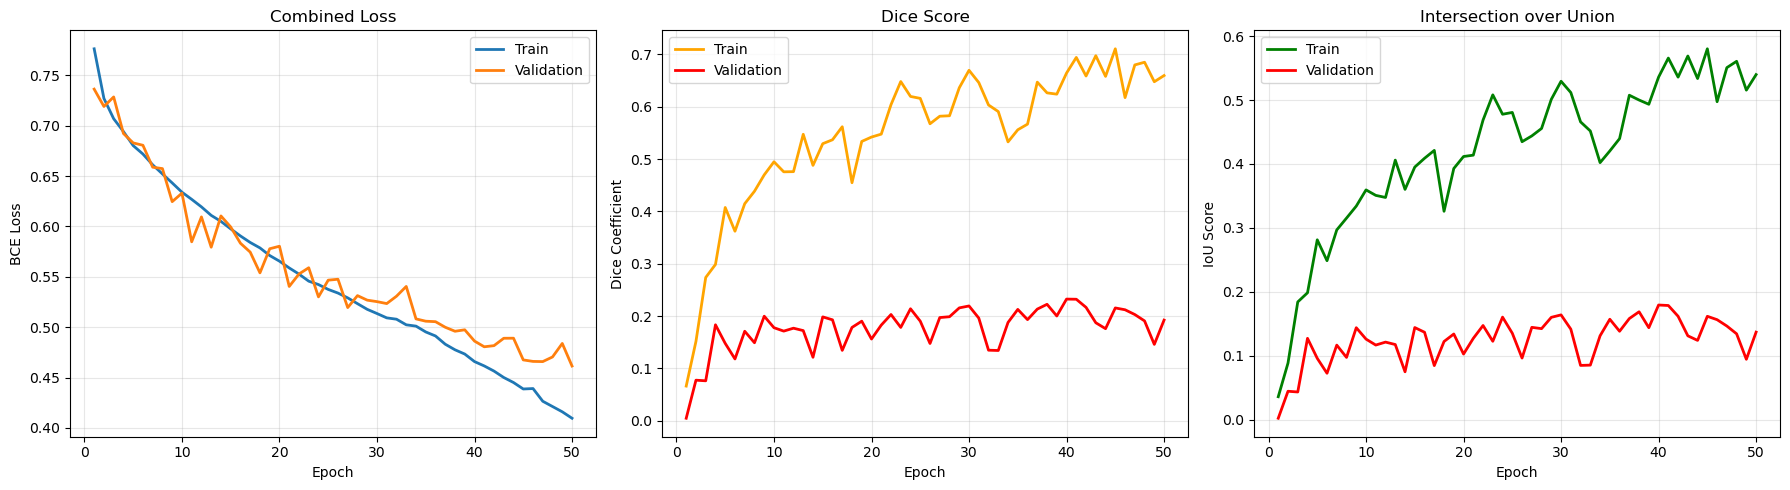

In [15]:
def plot_training_curves(history):
    """Plot training and validation curves"""
    epochs = range(1, len(history['train_loss']) + 1)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # BCE Loss
    axes[0].plot(epochs, history['train_loss'], label='Train', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], label='Validation', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('BCE Loss')
    axes[0].set_title('Combined Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Dice Score
    axes[1].plot(epochs, history['train_dice'], label='Train', linewidth=2, color='orange')
    axes[1].plot(epochs, history['val_dice'], label='Validation', linewidth=2, color='red')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Dice Coefficient')
    axes[1].set_title('Dice Score')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # IoU Score
    axes[2].plot(epochs, history['train_iou'], label='Train', linewidth=2, color='green')
    axes[2].plot(epochs, history['val_iou'], label='Validation', linewidth=2, color='red')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('IoU Score')
    axes[2].set_title('Intersection over Union')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_curves(history)

# Classification from Segmentation Masks

In [16]:
def classify_from_mask(mask_pred, mask_true, threshold=0.5, epsilon=1e-7):

    pred_binary = (mask_pred > threshold).float()
    true_binary = (mask_true > threshold).float()

    # Compute Dice coefficient
    intersection = (pred_binary * true_binary).sum().item()
    pred_sum = pred_binary.sum().item()  # Count of pixels with value 1
    true_sum = true_binary.sum().item()

    dice = (2.0 * intersection) / (pred_sum + true_sum + epsilon)

    # Compute IoU
    union = pred_sum + true_sum - intersection
    iou = intersection / (union + epsilon)


    predicted_class = 1 if pred_sum > 0 else 0

    return predicted_class, dice, iou

In [17]:
def evaluate_segmentation_and_classification(model, dataloader, split_name="Test"):
    """
    Evaluate both segmentation and classification.
    Classification is derived from segmentation quality (Dice/IoU scores).
    """
    model.eval()

    # Segmentation metrics
    all_seg_preds = []
    all_seg_true = []

    # Classification metrics
    all_clf_preds = []
    all_clf_true = []

    # Per-sample metrics for analysis
    all_dice_scores = []
    all_iou_scores = []

    print("\n" + "="*70)
    print(f"🔍 EVALUATING ON {split_name.upper()} SET")
    print("="*70)
    print("Classification based on: Segmentation probabilities [0, 1] from sigmoid")
    print("Metrics computed: Dice & IoU for each sample\n")

    with torch.no_grad():
        for images, masks, clf_labels in tqdm(dataloader, desc=f"Evaluating {split_name}"):
            images = images.to(device)

            # Stage 1: Segmentation
            seg_logits = model(images)
            seg_probs = torch.sigmoid(seg_logits)

            # Store segmentation predictions
            all_seg_preds.append(seg_probs.cpu())
            all_seg_true.append(masks.cpu())

            # Stage 2: Classification from segmentation quality
            for i in range(seg_probs.size(0)):
                # Compute classification using Dice/IoU
                pred_label, dice, iou = classify_from_mask(
                    seg_probs[i].cpu(),
                    masks[i].cpu()
                )
                true_label = clf_labels[i].item()

                all_clf_preds.append(pred_label)
                all_clf_true.append(true_label)
                all_dice_scores.append(dice)
                all_iou_scores.append(iou)

    # Concatenate segmentation results
    seg_preds = torch.cat(all_seg_preds, dim=0)
    seg_true = torch.cat(all_seg_true, dim=0)

    # ===============================
    # SEGMENTATION METRICS
    # ===============================
    pred_binary = (seg_preds > 0.5).float()
    true_binary = (seg_true > 0.5).float()

    pred_flat = pred_binary.view(-1)
    true_flat = true_binary.view(-1)

    TP = (pred_flat * true_flat).sum().item()
    FP = (pred_flat * (1 - true_flat)).sum().item()
    FN = ((1 - pred_flat) * true_flat).sum().item()
    TN = ((1 - pred_flat) * (1 - true_flat)).sum().item()

    epsilon = 1e-7

    iou = TP / (TP + FP + FN + epsilon)
    dice = (2 * TP) / (2 * TP + FP + FN + epsilon)
    pixel_acc = (TP + TN) / (TP + TN + FP + FN + epsilon)
    sensitivity = TP / (TP + FN + epsilon)
    specificity = TN / (TN + FP + epsilon)
    precision = TP / (TP + FP + epsilon)

    # Compute BCE loss
    bce_loss = seg_criterion(torch.logit(seg_preds.clamp(epsilon, 1-epsilon)), seg_true).item()

    seg_metrics = {
        'IoU': iou,
        'Dice': dice,
        'BCE_Loss': bce_loss,
        'Pixel_Accuracy': pixel_acc,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision
    }

    print("\n" + "🎯 SEGMENTATION METRICS ".center(70, "="))
    print(f"  Dice Coefficient: {seg_metrics['Dice']:.4f}")
    print(f"  IoU Score: {seg_metrics['IoU']:.4f}")
    print(f"  BCE Loss: {seg_metrics['BCE_Loss']:.4f}")
    print(f"  Pixel Accuracy: {seg_metrics['Pixel_Accuracy']:.4f}")
    print(f"  Sensitivity (Recall): {seg_metrics['Sensitivity']:.4f}")
    print(f"  Specificity: {seg_metrics['Specificity']:.4f}")
    print(f"  Precision: {seg_metrics['Precision']:.4f}")

    # ===============================
    # CLASSIFICATION METRICS
    # ===============================
    all_clf_preds = np.array(all_clf_preds)
    all_clf_true = np.array(all_clf_true)
    all_dice_scores = np.array(all_dice_scores)
    all_iou_scores = np.array(all_iou_scores)

    # Confusion matrix
    TP_clf = np.sum((all_clf_preds == 1) & (all_clf_true == 1))
    TN_clf = np.sum((all_clf_preds == 0) & (all_clf_true == 0))
    FP_clf = np.sum((all_clf_preds == 1) & (all_clf_true == 0))
    FN_clf = np.sum((all_clf_preds == 0) & (all_clf_true == 1))

    cm = np.array([[TN_clf, FP_clf], [FN_clf, TP_clf]])

    accuracy = (TP_clf + TN_clf) / (TP_clf + TN_clf + FP_clf + FN_clf + epsilon)
    precision_clf = TP_clf / (TP_clf + FP_clf + epsilon)
    recall_clf = TP_clf / (TP_clf + FN_clf + epsilon)
    f1_score = 2 * (precision_clf * recall_clf) / (precision_clf + recall_clf + epsilon)

    # Average Dice/IoU for each classification outcome
    tp_indices = (all_clf_preds == 1) & (all_clf_true == 1)
    tn_indices = (all_clf_preds == 0) & (all_clf_true == 0)
    fp_indices = (all_clf_preds == 1) & (all_clf_true == 0)
    fn_indices = (all_clf_preds == 0) & (all_clf_true == 1)

    avg_dice_tp = all_dice_scores[tp_indices].mean() if tp_indices.sum() > 0 else 0
    avg_dice_tn = all_dice_scores[tn_indices].mean() if tn_indices.sum() > 0 else 0
    avg_dice_fp = all_dice_scores[fp_indices].mean() if fp_indices.sum() > 0 else 0
    avg_dice_fn = all_dice_scores[fn_indices].mean() if fn_indices.sum() > 0 else 0

    clf_metrics = {
        'Confusion_Matrix': cm,
        'Accuracy': accuracy,
        'Precision': precision_clf,
        'Recall': recall_clf,
        'F1_Score': f1_score,
        'Avg_Dice_TP': avg_dice_tp,
        'Avg_Dice_TN': avg_dice_tn,
        'Avg_Dice_FP': avg_dice_fp,
        'Avg_Dice_FN': avg_dice_fn,
        'Mean_Dice': all_dice_scores.mean(),
        'Mean_IoU': all_iou_scores.mean()
    }

    print("\n" + "🎯 CLASSIFICATION METRICS (from Seg Probs [0,1]) ".center(70, "="))
    print(f"  Accuracy: {clf_metrics['Accuracy']:.4f}")
    print(f"  Precision: {clf_metrics['Precision']:.4f}")
    print(f"  Recall: {clf_metrics['Recall']:.4f}")
    print(f"  F1-Score: {clf_metrics['F1_Score']:.4f}")
    print(f"\n  Per-Sample Metrics:")
    print(f"    Mean Dice: {clf_metrics['Mean_Dice']:.4f}")
    print(f"    Mean IoU: {clf_metrics['Mean_IoU']:.4f}")
    print(f"\n  Average Dice by Classification:")
    print(f"    True Positives (TP): {avg_dice_tp:.4f}")
    print(f"    True Negatives (TN): {avg_dice_tn:.4f}")
    print(f"    False Positives (FP): {avg_dice_fp:.4f}")
    print(f"    False Negatives (FN): {avg_dice_fn:.4f}")

    # Plot Confusion Matrix
    print("\n" + "📊 CONFUSION MATRIX ".center(70, "="))

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, cmap='Blues', interpolation='nearest')

    plt.colorbar(im, ax=ax)

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['No Tumor', 'Tumor'])
    ax.set_yticklabels(['No Tumor', 'Tumor'])

    # Add text annotations
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, int(cm[i, j]),
                          ha="center", va="center",
                          color="white" if cm[i, j] > cm.max()/2 else "black",
                          fontsize=16, fontweight='bold')

    ax.set_title(f"Classification from Segmentation Probabilities [0,1] ({split_name})\nAccuracy: {clf_metrics['Accuracy']:.3f} | Mean Dice: {clf_metrics['Mean_Dice']:.3f}",
                 fontsize=14, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

    print("\n" + "="*70 + "\n")

    return seg_metrics, clf_metrics


🔍 EVALUATING ON TEST SET
Classification based on: Segmentation probabilities [0, 1] from sigmoid
Metrics computed: Dice & IoU for each sample



Evaluating Test: 100%|██████████| 12/12 [00:04<00:00,  2.62it/s]



=======================🎯 SEGMENTATION METRICS ========================
  Dice Coefficient: 0.5837
  IoU Score: 0.4121
  BCE Loss: 0.4744
  Pixel Accuracy: 0.9961
  Sensitivity (Recall): 0.7083
  Specificity: 0.9972
  Precision: 0.4964

===========🎯 CLASSIFICATION METRICS (from Seg Probs [0,1]) ===========
  Accuracy: 0.5870
  Precision: 0.4242
  Recall: 1.0000
  F1-Score: 0.5957

  Per-Sample Metrics:
    Mean Dice: 0.1896
    Mean IoU: 0.1482

  Average Dice by Classification:
    True Positives (TP): 0.6230
    True Negatives (TN): 0.0000
    False Positives (FP): 0.0000
    False Negatives (FN): 0.0000

=========================📊 CONFUSION MATRIX ==========================


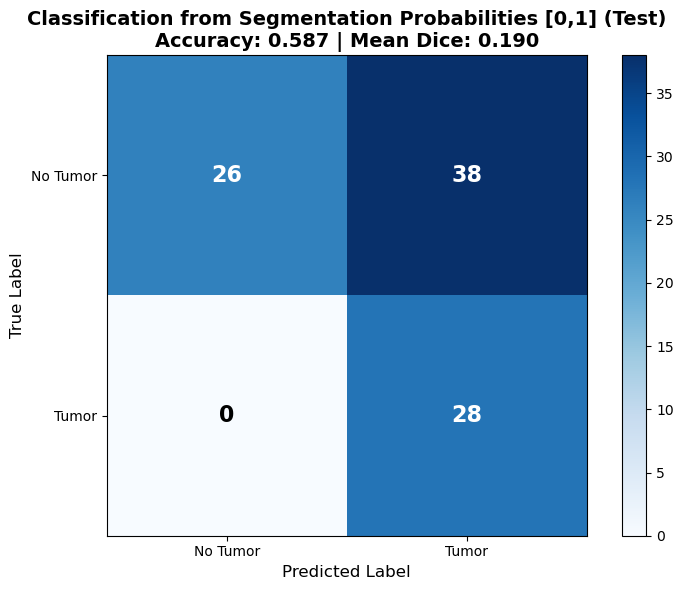

In [18]:
#Evaluate on test set
test_seg_metrics, test_clf_metrics = evaluate_segmentation_and_classification(
    unetpp, test_loader, split_name="Test"
)

# Show predictions


In [19]:
#Inspect what the loader yields
batch = next(iter(train_loader))
print(type(batch))
print(len(batch))


<class 'list'>
3


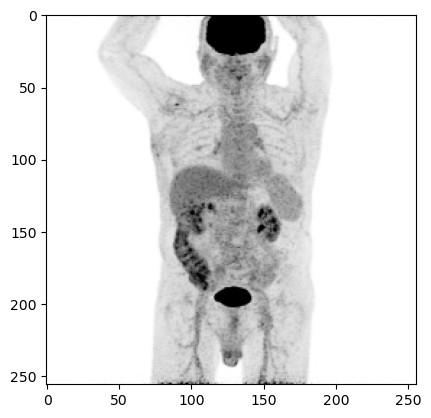

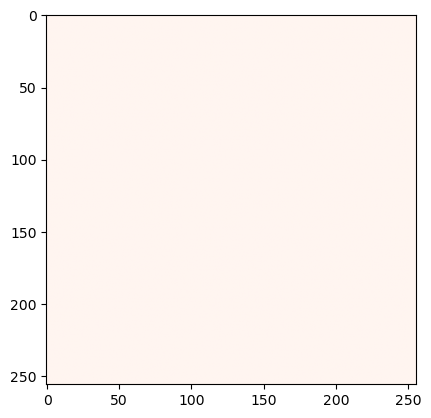

In [20]:
# Display image and label.
train_features, train_labels, _ = next(iter(train_loader))
#print(f"Feature batch shape: {train_features.size()}")
#print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0].squeeze()
plt.imshow(img, cmap="gray")
plt.show()
plt.imshow(label, cmap="Reds")
plt.show()
#print(f"Label: {label}")

In [21]:
def predict(model, image, device):
    model.eval()

    # Ensure correct shape
    if len(image.shape) == 2:
        image = image.unsqueeze(0).unsqueeze(0)  # Add batch and channel dims
    elif len(image.shape) == 3:
        image = image.unsqueeze(0)  # Add batch dim

    image = image.to(device)

    with torch.no_grad():
        output = model(image)

        # Get final output if deep supervision
        if isinstance(output, list):
            output = output[-1]

        # Get probabilities
        probs = torch.sigmoid(output)
        tumor_prob = probs
        pred_mask = (tumor_prob > 0.5).float()

    return pred_mask.squeeze().cpu(), tumor_prob.squeeze().cpu()

In [ ]:
train_features, train_labels, _ = next(iter(train_loader))

pred_mask, _ = predict(unetpp, train_features[0].squeeze(), device)

# Visualize prediction
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(train_features[0].squeeze(), cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(train_labels[0].squeeze(), cmap='gray')
axes[1].set_title('Tumor Mask')
axes[1].axis('off')

axes[2].imshow(pred_mask, cmap='gray')
axes[2].set_title('Predicted Tumor Mask')
axes[2].axis('off')

plt.tight_layout()
plt.savefig('prediction_result.png', dpi=300, bbox_inches='tight')
plt.show()